## Using NLP Methods to extract meaning from free text for supervised modelling 📜🗣️

### The data: Rent prices in Vienna, scraped previously from [Willhaben.at](https://www.willhaben.at)

In [1]:
import numpy as np
import pandas as pd
from plotnine import *

import string
import re
import nltk

Firstly, let's load in the data:

In [2]:
# import data
data = (pd.read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/08 - Tokenisation/Willhaben_everything_clean.csv")
        .astype({"landlord":"category"})
        )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7655 entries, 0 to 7654
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   title     7655 non-null   object  
 1   price     7655 non-null   float64 
 2   sqm       7655 non-null   int64   
 3   rooms     7581 non-null   float64 
 4   postcode  7653 non-null   float64 
 5   landlord  7655 non-null   category
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 335.0+ KB


There isn't too much information available, but the point is the tokenisation anyways:

In [4]:
data.head()

,title,price,sqm,rooms,postcode,landlord
0,Provisionsfreie 2-Zimmer Wohnung in Ober St. V...,780.00,47,2.0,1130.0,Privat
1,Dringend Nachmieter gesucht!! Wunderschöne hel...,795.00,43,2.0,1120.0,Privat
2,*URBANES WOHNEN*PROVISIONSFREI* ERSTBEZUG*RIVU...,1114.47,70,3.0,1230.0,BUWOG Group GmbH
3,+++ THE ONE! PROVISIONSFREI! TOLL GESCHNITTENE...,895.00,48,2.0,1030.0,Privat
4,Provisionsfrei - Renovierte 3-Zimmer mit Loggi...,1073.00,78,3.0,1140.0,Privat


In [5]:
data.value_counts("postcode")

postcode
1220.0    1082
1210.0     974
1200.0     779
1100.0     510
1110.0     377
1030.0     371
1140.0     346
1190.0     341
1120.0     317
1160.0     265
1180.0     244
1020.0     244
1230.0     211
1010.0     209
1130.0     197
1050.0     185
1060.0     171
1150.0     164
1090.0     158
1040.0     151
1170.0     141
1080.0     115
1070.0     100
9999.0       1
dtype: int64

There are 24 different postcodes, of which all conveniently have enough data, except for postcode 9999, which I will drop (presumably a mistake).

In [6]:
data.value_counts('landlord').to_frame()

,0
landlord,
teamneunzehn-Gruppe,1277
Privat,832
EHL Immobilien GmbH,396
Haring Immobilien Treuhand GmbH,319
IMMOcontract Immobilien Vermittlung GmbH,172
...,...
Cardo Immobilienvermittlung GmbH,1
RED Real Estates Development Bauträger und Immobilien GmbH,1
RELAX Immobilien GmbH,1


There are 611 different landlords, which is too much to be used. I will lump infrequent levels into an 'other' category in the `sklearn` pipeline.

In [7]:
data.sample(10).title.tolist()

['PROVISIONSFREI! Unbefristet wohnen in ruhiger Lage nahe der Seestadt! AKTION! 1 Monat Mietzinsfrei!',
 'Fully FURNISHED, beautiful APARTMENT in the Heart of Vienna on the 6th Floor next to the STATE OPERA',
 'INKL. HEIZKOSTEN - DG-WOHNUNG + TERRASSE',
 'Provisionsfreie 2-Zimmer-Wohnung mit ca. 10 m² Terrasse',
 'PROVISIONFREI UND 2 MONATE MIETFREI - Erstbezug 2-Zimmer-Neubauwohnung inkl hochwertiger Markenküche mit Geschirrspüler und Mikrowelle, Außenfläche und Kellerabteil / ALF52 Top 2-17',
 'LAENDYARD - Singlehit mit Balkon',
 'NUSSGASSE / Stilhaus / unbefristete helle 68 m2 Altbaumiete / Durchgangszimmer',
 'Top 51 Moderner Erstbezug | U3 Enkplatz | Terrasse',
 'Duplex Wohnung, Dachgeschoß 3Zi. + Terrasse, Großzügig, Zentral, Perfekte Grundriss!',
 'Repräsentative Altbauetage beim Schwarzenbergplatz, unbefristet']

The title of the listing contains some additional information about the listing that might be useful in making predictions. However, some cleaning is required beforehand.

1. Removing punctuation


In [8]:
" ".join(string.punctuation)

'! " # $ % & \' ( ) * + , - . / : ; < = > ? @ [ \\ ] ^ _ ` { | } ~'

Using the following function, I can replace all punctuation characters with white spaces:

In [9]:
def remove_punctuation(text):
    return text.translate({ord(x): ' ' for x in string.punctuation})

2. Lower casing: using `lower()`

See below


3. Tokenisation

In [10]:
def tokenisation(text):
    text = " ".join(text.strip().split())
    tokens = re.split(' ', text)
    return tokens

In [11]:
(data
    .assign(title_tokens = lambda x: x['title'].apply(tokenisation))    
)

,title,price,sqm,rooms,postcode,landlord,title_tokens
0,Provisionsfreie 2-Zimmer Wohnung in Ober St. V...,780.00,47,2.0,1130.0,Privat,"[Provisionsfreie, 2-Zimmer, Wohnung, in, Ober,..."
1,Dringend Nachmieter gesucht!! Wunderschöne hel...,795.00,43,2.0,1120.0,Privat,"[Dringend, Nachmieter, gesucht!!, Wunderschöne..."
2,*URBANES WOHNEN*PROVISIONSFREI* ERSTBEZUG*RIVU...,1114.47,70,3.0,1230.0,BUWOG Group GmbH,"[*URBANES, WOHNEN*PROVISIONSFREI*, ERSTBEZUG*R..."
3,+++ THE ONE! PROVISIONSFREI! TOLL GESCHNITTENE...,895.00,48,2.0,1030.0,Privat,"[+++, THE, ONE!, PROVISIONSFREI!, TOLL, GESCHN..."
4,Provisionsfrei - Renovierte 3-Zimmer mit Loggi...,1073.00,78,3.0,1140.0,Privat,"[Provisionsfrei, -, Renovierte, 3-Zimmer, mit,..."
...,...,...,...,...,...,...,...
7650,"Charmante 2-Zimmer Wohnung, Privat, 38 m², hel...",550.00,38,2.0,1210.0,Privat,"[Charmante, 2-Zimmer, Wohnung,, Privat,, 38, m..."
7651,Grenzenloser Weitblick - Einzigartig wohnen im...,741.65,41,2.0,1210.0,s REAL - Wien,"[Grenzenloser, Weitblick, -, Einzigartig, wohn..."
7652,NUSSGASSE / Stilhaus / unbefristete helle 68 m...,899.35,68,3.0,1090.0,NEW Immobilien,"[NUSSGASSE, /, Stilhaus, /, unbefristete, hell..."
7653,Reizende 1-Zimmerwohnung in Unter Sankt Veit,590.78,41,1.0,1130.0,Sajowitz Immobilien,"[Reizende, 1-Zimmerwohnung, in, Unter, Sankt, ..."


In the `sklearn` pipeline, I can use the CountVectorizer function in order to do the tokenisation.

4. Removing stopwords

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords.words('german')]

#### Final preprocessing:

In [15]:
data = (data
        .query('postcode != 9999')
        .assign(title=lambda x: x['title'].apply(remove_punctuation))
        .assign(title=lambda x: x['title'].str.lower())
        # .assign(title_tokens = lambda x: x['title'].apply(tokenisation))
        # .assign(title_tokens = lambda x: x['title_tokens'].apply(remove_stopwords))
        .assign(title_length = lambda x: x['title'].apply(len))
        )

data['rooms'] = data['rooms'].astype('category')
data['postcode'] = data['postcode'].astype('category')

data.head()

,title,price,sqm,rooms,postcode,landlord,title_length
0,provisionsfreie 2 zimmer wohnung in ober st v...,780.00,47,2.0,1130.0,Privat,77
1,dringend nachmieter gesucht wunderschöne hel...,795.00,43,2.0,1120.0,Privat,101
2,urbanes wohnen provisionsfrei erstbezug rivu...,1114.47,70,3.0,1230.0,BUWOG Group GmbH,97
3,the one provisionsfrei toll geschnittene...,895.00,48,2.0,1030.0,Privat,188
4,provisionsfrei renovierte 3 zimmer mit loggi...,1073.00,78,3.0,1140.0,Privat,53


### EDA

Price distribution?

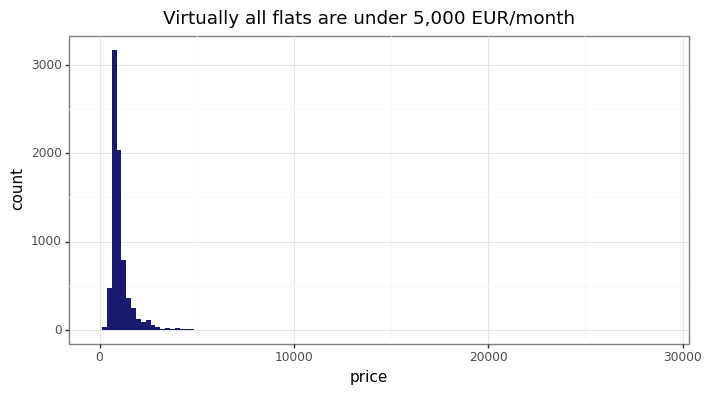

<ggplot: (76020586827)>

In [16]:
(
    ggplot(data=data,
           mapping=aes(x='price')) +
    geom_histogram(fill='midnightblue', binwidth=250) +
    labs(title='Virtually all flats are under 5,000 EUR/month') +
    # scale_x_log10() +
    theme_bw() +
    theme(figure_size=[8,4])
)

Distribution of target with numerical predictors:

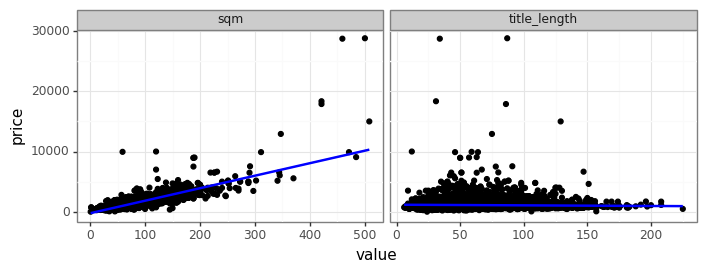

<ggplot: (76021217160)>

In [17]:
(
    ggplot(data=(data
                 .select_dtypes(include="number")
                 .melt(id_vars='price')
                 ),
           mapping=aes(x='value', y='price')) +
    geom_point() +
    facet_wrap('~ variable', scales='free_x') +
    geom_smooth(colour='blue') +
    theme_bw() +
    theme(figure_size=[8, 2.5],
          subplots_adjust={'hspace': 0.4})
)


Distribution of target with nominal predictors:
- need to keep only the top levels for the factors here, because the plot with be too crowded otherwise

In [18]:
top_landlords = data.value_counts('landlord').head(10).index.tolist()

top_landlords

['teamneunzehn-Gruppe',
 'Privat',
 'EHL Immobilien GmbH',
 'Haring Immobilien Treuhand GmbH',
 'IMMOcontract Immobilien Vermittlung GmbH',
 'OPTIN Immobilien GmbH',
 'IMV Makler GmbH',
 'Gewerblicher Anbieter',
 'Hubner Immobilien',
 's REAL - Wien']

In [19]:
# Lumping together category levels
(data
 .assign(landlord = lambda x: x['landlord'].apply(lambda r: r if r in top_landlords else "other"))
 .value_counts('landlord')
 )

landlord
other                                       4069
teamneunzehn-Gruppe                         1277
Privat                                       832
EHL Immobilien GmbH                          396
Haring Immobilien Treuhand GmbH              319
IMMOcontract Immobilien Vermittlung GmbH     172
OPTIN Immobilien GmbH                        135
IMV Makler GmbH                              121
Gewerblicher Anbieter                        120
Hubner Immobilien                            108
s REAL - Wien                                105
dtype: int64

In [20]:
data.head()

,title,price,sqm,rooms,postcode,landlord,title_length
0,provisionsfreie 2 zimmer wohnung in ober st v...,780.00,47,2.0,1130.0,Privat,77
1,dringend nachmieter gesucht wunderschöne hel...,795.00,43,2.0,1120.0,Privat,101
2,urbanes wohnen provisionsfrei erstbezug rivu...,1114.47,70,3.0,1230.0,BUWOG Group GmbH,97
3,the one provisionsfrei toll geschnittene...,895.00,48,2.0,1030.0,Privat,188
4,provisionsfrei renovierte 3 zimmer mit loggi...,1073.00,78,3.0,1140.0,Privat,53


### Training a Model

In [21]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

config_context(transform_output="pandas")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Won't need the following function, as I'll be using the default CountVectorizer() anyways...

In [22]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords.words('german')]

def MyCustomTokenizer(text):
    text = " ".join(text.strip().split())
    tokens = re.split(' ', text)
    tokens = remove_stopwords(tokens)
    return tokens

In [23]:
(data
 .assign(title_tokens=lambda x: x['title'].apply(MyCustomTokenizer))
 )


,title,price,sqm,rooms,postcode,landlord,title_length,title_tokens
0,provisionsfreie 2 zimmer wohnung in ober st v...,780.00,47,2.0,1130.0,Privat,77,"[provisionsfreie, 2, zimmer, wohnung, ober, st..."
1,dringend nachmieter gesucht wunderschöne hel...,795.00,43,2.0,1120.0,Privat,101,"[dringend, nachmieter, gesucht, wunderschöne, ..."
2,urbanes wohnen provisionsfrei erstbezug rivu...,1114.47,70,3.0,1230.0,BUWOG Group GmbH,97,"[urbanes, wohnen, provisionsfrei, erstbezug, r..."
3,the one provisionsfrei toll geschnittene...,895.00,48,2.0,1030.0,Privat,188,"[the, one, provisionsfrei, toll, geschnittene,..."
4,provisionsfrei renovierte 3 zimmer mit loggi...,1073.00,78,3.0,1140.0,Privat,53,"[provisionsfrei, renovierte, 3, zimmer, loggia..."
...,...,...,...,...,...,...,...,...
7650,charmante 2 zimmer wohnung privat 38 m² hel...,550.00,38,2.0,1210.0,Privat,106,"[charmante, 2, zimmer, wohnung, privat, 38, m²..."
7651,grenzenloser weitblick einzigartig wohnen im...,741.65,41,2.0,1210.0,s REAL - Wien,108,"[grenzenloser, weitblick, einzigartig, wohnen,..."
7652,nussgasse stilhaus unbefristete helle 68 m...,899.35,68,3.0,1090.0,NEW Immobilien,78,"[nussgasse, stilhaus, unbefristete, helle, 68,..."
7653,reizende 1 zimmerwohnung in unter sankt veit,590.78,41,1.0,1130.0,Sajowitz Immobilien,44,"[reizende, 1, zimmerwohnung, sankt, veit]"


In [24]:
X, y = data.drop("price", axis=1), data.price

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [26]:
X

,title,sqm,rooms,postcode,landlord,title_length
0,provisionsfreie 2 zimmer wohnung in ober st v...,47,2.0,1130.0,Privat,77
1,dringend nachmieter gesucht wunderschöne hel...,43,2.0,1120.0,Privat,101
2,urbanes wohnen provisionsfrei erstbezug rivu...,70,3.0,1230.0,BUWOG Group GmbH,97
3,the one provisionsfrei toll geschnittene...,48,2.0,1030.0,Privat,188
4,provisionsfrei renovierte 3 zimmer mit loggi...,78,3.0,1140.0,Privat,53
...,...,...,...,...,...,...
7650,charmante 2 zimmer wohnung privat 38 m² hel...,38,2.0,1210.0,Privat,106
7651,grenzenloser weitblick einzigartig wohnen im...,41,2.0,1210.0,s REAL - Wien,108
7652,nussgasse stilhaus unbefristete helle 68 m...,68,3.0,1090.0,NEW Immobilien,78
7653,reizende 1 zimmerwohnung in unter sankt veit,41,1.0,1130.0,Sajowitz Immobilien,44


No mixed data types:

In [27]:
for column in data.applymap(type).columns:
    print(column)
    print(data.applymap(type)[column].value_counts())
    print("____________________________")

title
<class 'str'>    7654
Name: title, dtype: int64
____________________________
price
<class 'float'>    7654
Name: price, dtype: int64
____________________________
sqm
<class 'int'>    7654
Name: sqm, dtype: int64
____________________________
rooms
<class 'float'>    7654
Name: rooms, dtype: int64
____________________________
postcode
<class 'float'>    7654
Name: postcode, dtype: int64
____________________________
landlord
<class 'str'>    7654
Name: landlord, dtype: int64
____________________________
title_length
<class 'int'>    7654
Name: title_length, dtype: int64
____________________________


### Pipeline without Tokenisation

In [28]:
# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(sparse_output=False,
     max_categories=20, handle_unknown='ignore'))
])

# Making column transformer where all transformers in the pipelines are included
preprocessor_notokens = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, ['sqm', 'title_length']),
        ("categorical", categorical_transformer, ['rooms', 'postcode', 'landlord'])
    ],
    remainder="drop"
)

# Making model pipeline for lightgbm
lgbm_pipeline_notokens = Pipeline(steps=[
    ("preprocessing", preprocessor_notokens),
    ("LGBMmodel", LGBMRegressor())
])

xg_pipeline_notokens = Pipeline(steps=[
    ("preprocessing", preprocessor_notokens),
    ("XGmodel", XGBRegressor())
])


In [29]:
# see transformed dataset
pd.DataFrame(lgbm_pipeline_notokens[:-1].fit_transform(X_train, y_train),
             columns=lgbm_pipeline_notokens[:-1].get_feature_names_out().tolist())

,numeric__sqm,numeric__title_length,categorical__rooms_1.0,categorical__rooms_2.0,categorical__rooms_3.0,categorical__rooms_4.0,categorical__rooms_5.0,categorical__rooms_6.0,categorical__rooms_7.0,categorical__rooms_8.0,...,categorical__landlord_Moritz Immobilientreuhand GmbH,categorical__landlord_OPTIN Immobilien GmbH,categorical__landlord_Privat,categorical__landlord_RAAB & Partner Immobilien Gesellschaft m.b.H.,categorical__landlord_Steindl & Herzel Immobilien OG,categorical__landlord_homefinding.at  Mag Janauer & Göllner GmbH,categorical__landlord_s REAL - Wien,categorical__landlord_teamneunzehn-Gruppe,categorical__landlord_ÖRAG Immobilien Vermittlung GmbH,categorical__landlord_infrequent_sklearn
0,0.069261,-0.656637,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.339148,1.661578,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.360981,-0.302465,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.397492,0.566866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.344682,-1.783547,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,-0.397492,1.532789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5736,-0.251632,-0.463452,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5737,0.010917,-0.109281,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5738,-0.251632,2.305527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only 54 columns in this one, as the title column is just not used as a predictor.

### Pipeline with Tokenisation

I can also specify a list of stopwords that I don't want to use. I'll use the NLTK ones in German, as the listings come from a German website.

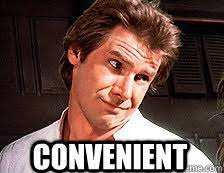

In [30]:
# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(sparse_output=False, max_categories=20, handle_unknown='ignore'))
])

tokens_transformer = Pipeline([
    ('vect', CountVectorizer(max_features=100, stop_words=stopwords.words('german')))
])

# Making column transformer where all transformers in the pipelines are included
preprocessor_tokens = ColumnTransformer(
    transformers=[("title", tokens_transformer, 'title'),
                  ("numeric", numeric_transformer, ['sqm', 'title_length']),
                  ("categorical", categorical_transformer, ['rooms', 'postcode', 'landlord'])],
    remainder="passthrough"
)

# Making model pipeline for lightgbm
lgbm_pipeline_withtokens = Pipeline(steps=[
    ("preprocessing", preprocessor_tokens),
    ("LGBMmodel", LGBMRegressor())
])

xg_pipeline_withtokens = Pipeline(steps=[
    ("preprocessing", preprocessor_tokens),
    ("XGmodel", XGBRegressor())
])


In [31]:
# see transformed dataset
pd.DataFrame(lgbm_pipeline_withtokens[:-1].fit_transform(X_train, y_train),
             columns=lgbm_pipeline_withtokens[:-1].get_feature_names_out().tolist())

,title__ab,title__aktion,title__altbau,title__altbauwohnung,title__anfragen,title__apartment,title__aufstrebender,title__außenfläche,title__bahn,title__bahnhof,...,categorical__landlord_Moritz Immobilientreuhand GmbH,categorical__landlord_OPTIN Immobilien GmbH,categorical__landlord_Privat,categorical__landlord_RAAB & Partner Immobilien Gesellschaft m.b.H.,categorical__landlord_Steindl & Herzel Immobilien OG,categorical__landlord_homefinding.at  Mag Janauer & Göllner GmbH,categorical__landlord_s REAL - Wien,categorical__landlord_teamneunzehn-Gruppe,categorical__landlord_ÖRAG Immobilien Vermittlung GmbH,categorical__landlord_infrequent_sklearn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


154 columns in this one, as 100 tokens are created from the title column, ignoring the stopwords provided. Much much easier than writing my own function, this is arguably even easier than tidymodels...

### Hyperparameter Tuning without Tokens

In [32]:
# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
lgbm_grid = {
    'LGBMmodel__num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    'LGBMmodel__max_depth': [int(x) for x in np.linspace(start=1, stop=100, num=20)],
    # 'LGBMmodel__learning_rate' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5],
    'LGBMmodel__subsample': [0.4, 0.6, 0.8, 1]
}

In [33]:
lgbm_search_notokens = (RandomizedSearchCV(lgbm_pipeline_notokens, param_distributions=lgbm_grid, n_iter=200,
                                           verbose=1, cv=3, scoring="neg_mean_squared_error")
                        .fit(X_train, y_train))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [34]:
# Select the hyperparams and the score from the results
lgbm_search_results_notokens = (pd.DataFrame(lgbm_search_notokens.cv_results_)
                       .filter(["param_" + x for x in list(lgbm_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
lgbm_search_results_notokens.columns = lgbm_search_results_notokens.columns.str.replace("param_LGBMmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
lgbm_search_results_notokens.describe()


,mean_test_score
count,200.000000
mean,-344197.597724
std,23179.454777
min,-408484.877279
25%,-341961.588162
50%,-333865.012473
75%,-332493.427335
max,-331773.682873


In [35]:
lgbm_search_notokens.best_params_

{'LGBMmodel__subsample': 0.4,
 'LGBMmodel__num_leaves': 4096,
 'LGBMmodel__max_depth': 37}

### Hyperparameter Tuning with Tokens

In [36]:
lgbm_search_withtokens = (RandomizedSearchCV(lgbm_pipeline_withtokens, param_distributions=lgbm_grid, n_iter=200,
                                             verbose=1, cv=3, scoring="neg_mean_squared_error")
                          .fit(X_train, y_train))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [37]:
# Select the hyperparams and the score from the results
lgbm_search_results_withtokens = (pd.DataFrame(lgbm_search_withtokens.cv_results_)
                       .filter(["param_" + x for x in list(lgbm_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
lgbm_search_results_withtokens.columns = lgbm_search_results_withtokens.columns.str.replace("param_LGBMmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
lgbm_search_results_withtokens.describe()


,mean_test_score
count,200.000000
mean,-337322.022585
std,28181.214342
min,-406385.887254
25%,-338323.146214
50%,-323459.240370
75%,-322507.123789
max,-320673.798062


In [38]:
lgbm_search_withtokens.best_params_

{'LGBMmodel__subsample': 0.4,
 'LGBMmodel__num_leaves': 128,
 'LGBMmodel__max_depth': 21}

### Compare the approaches with and without Tokenisation

In [39]:
# Print the metrics for LGBM: No need to refit, automatically selects the best from the grid
print("LGBM Metrics with tokenisation:")
print("--------------------------------")
print(f"R-Squared: {round(r2_score(y_pred=lgbm_search_withtokens.predict(X_test), y_true=y_test), 4)}")
print(f"MAE: {round(mean_absolute_error(y_pred=lgbm_search_withtokens.predict(X_test), y_true=y_test), 4)}")
print(f"MSE: {round(mean_squared_error(y_pred=lgbm_search_withtokens.predict(X_test), y_true=y_test), 4)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_pred=lgbm_search_withtokens.predict(X_test), y_true=y_test), 4)}")

LGBM Metrics with tokenisation:
--------------------------------
R-Squared: 0.6802
MAE: 138.2837
MSE: 122785.2414
MAPE: 0.5155


In [40]:
# Print the metrics for LGBM: No need to refit, automatically selects the best from the grid
print("LGBM Metrics without tokenisation:")
print("-----------------------------------")
print(f"R-Squared: {round(r2_score(y_pred=lgbm_search_notokens.predict(X_test), y_true=y_test), 4)}")
print(f"MAE: {round(mean_absolute_error(y_pred=lgbm_search_notokens.predict(X_test), y_true=y_test), 4)}")
print(f"MSE: {round(mean_squared_error(y_pred=lgbm_search_notokens.predict(X_test), y_true=y_test), 4)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_pred=lgbm_search_notokens.predict(X_test), y_true=y_test), 4)}")

LGBM Metrics without tokenisation:
-----------------------------------
R-Squared: 0.6422
MAE: 154.0333
MSE: 137378.0489
MAPE: 0.4992


### Conclusion: 4 ppts better $R^2$ and 16 EUR/month less absolut error on average. Tokenisation worked well in this case!

In [42]:
predictions = pd.concat([pd.DataFrame(
    {'predictions': lgbm_search_notokens.predict(X_test),
     'actuals': y_test,
     'model': 'No Tokens'}
),
    pd.DataFrame(
    {'predictions': lgbm_search_withtokens.predict(X_test),
     'actuals': y_test,
     'model': 'With Tokens'}
)]).query('actuals > 100')

predictions

,predictions,actuals,model
4274,1037.177350,999.99,No Tokens
6430,1465.310926,1399.83,No Tokens
6079,1087.191544,1664.28,No Tokens
4226,964.948757,948.99,No Tokens
6708,867.937509,749.00,No Tokens
...,...,...,...
3727,878.995017,678.21,With Tokens
7482,1214.434167,1174.99,With Tokens
940,791.420846,815.00,With Tokens
3599,1785.542805,1650.00,With Tokens


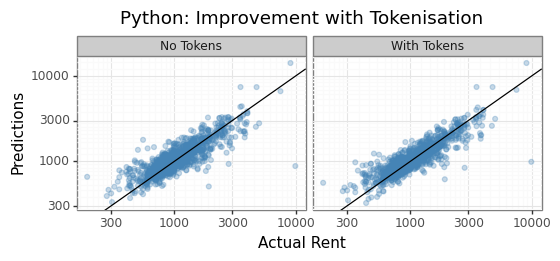

<ggplot: (76021284345)>

In [43]:
p = (
    ggplot(data=predictions, mapping=aes(x="actuals", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.3) +
    geom_abline() +
    labs(title="Python: Improvement with Tokenisation",
         y="Predictions", x="Actual Rent") +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap("~ model") +
    theme_bw() +
    theme(figure_size=[6, 2])
)

p


In [45]:
(p + theme(figure_size=[4,2.5])).save(dpi=350, filename="python.png")

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 4 x 2.5 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png
